In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pdb
from adjustText import adjust_text
import pandas as pd
import os

In [2]:
def get_val_metrics(runs, index=0, exclude_keyword='ignore'):
    run_f1_scores = {}
    run_auroc_val_scores = {}
    
    for run in runs:
        # print(run.name)
        if exclude_keyword.lower() not in run.name.lower():

            history = run.history(pandas=True)
            # pdb.set_trace()
            # print(run.id)
            # pdb.set_trace()
            val_f1_scores = history['f1_val'].dropna().tolist()
            auroc_val_scores = history['auroc_val'].dropna().tolist()
            
            run_f1_scores[run.id] = val_f1_scores
            run_auroc_val_scores[run.id] = auroc_val_scores
    
    # mean_f1_scores = [f1_scores[index] for f1_scores in run_f1_scores.values()]
    # mean_auroc_val_scores = [auroc_val_scores[index] for auroc_val_scores in run_auroc_val_scores.values()]
    
    # overall_mean_f1 = np.mean(mean_f1_scores)
    # overall_std_f1 = np.std(mean_f1_scores)
    
    # overall_mean_auroc_val = np.mean(mean_auroc_val_scores)
    # overall_std_auroc_val = np.std(mean_auroc_val_scores)
    
    # print(f"Mean F1 score for the {index}th epoch across all runs: {overall_mean_f1:.4f}")
    # print(f"Std. F1 score for the {index}th epoch across all runs: {overall_std_f1:.4f}")
    
    # print(f"Mean AUROC VAL score for the {index}th epoch across all runs: {overall_mean_auroc_val:.4f}")
    # print(f"Std. AUROC VAL score for the {index}th epoch across all runs: {overall_std_auroc_val:.4f}")
    return list(run_f1_scores.values()), list(run_auroc_val_scores.values())

def get_val_metrics_scan(runs, index=0, exclude_keyword='ignore'):
    run_f1_scores = {}
    run_auroc_val_scores = {}
    
    for run in runs:
        if exclude_keyword.lower() not in run.name.lower():
            # Use scan_history() instead of history()
            history_data = []
            for row in run.scan_history(keys=["f1_val", "auroc_val"]):
                history_data.append(row)
            
            # Convert to DataFrame
            history = pd.DataFrame(history_data)
            
            val_f1_scores = history['f1_val'].dropna().tolist()
            auroc_val_scores = history['auroc_val'].dropna().tolist()
            
            run_f1_scores[run.id] = val_f1_scores
            run_auroc_val_scores[run.id] = auroc_val_scores
    
    return list(run_f1_scores.values()), list(run_auroc_val_scores.values())

def get_mean_std(scores):
    means = [np.mean([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    stds = [np.std([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    return means, stds

MDL_COLOR = {
    'resnet50':'r',
    'uni':'b',
    'gigapath': 'g'
}

def plot_results(uni_res, resnet_res, gigapath_res, title, colors=MDL_COLOR):
    # Create the x-axis values
    

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10), dpi=150)

    resnet50_means, resnet50_stds = resnet_res
    uni_means, uni_stds = uni_res
    gigapath_means, gigapath_stds = gigapath_res
    
    x = range(0, len(resnet50_means))
    # Plot the mean with error bars
    ax.errorbar(x, resnet50_means, yerr=resnet50_stds, fmt='o', capsize=5, color=colors['resnet50'])
    ax.errorbar(x, uni_means, yerr=uni_stds, fmt='x', capsize=5, color=colors['uni'])
    ax.errorbar(x, gigapath_means, yerr=gigapath_stds, fmt='s', capsize=5, color=colors['gigapath'])

    # Connect the mean values with lines
    ax.plot(x, resnet50_means, linestyle='-', color=colors['resnet50'], label='resnet50')
    ax.plot(x, uni_means, linestyle='--', color=colors['uni'], label='uni')
    ax.plot(x, gigapath_means, linestyle='-.', color=colors['gigapath'], label='gigapath')
    # Create text annotations
    texts = []
    # for i in x:
    #     resnet_label = f'{resnet50_means[i]:.2f} ± {resnet50_stds[i]:.2f}'
    #     uni_label = f'{uni_means[i]:.2f} ± {uni_stds[i]:.2f}'
    #     gigapath_label = f'{gigapath_means[i]:.2f} ± {gigapath_stds[i]:.2f}'
        
    #     texts.append(ax.text(i, resnet50_means[i], resnet_label, color='r', ha='center', va='bottom'))
    #     texts.append(ax.text(i, uni_means[i], uni_label, color='b', ha='center', va='bottom'))
    #     texts.append(ax.text(i, gigapath_means[i], gigapath_label, color='g', ha='center', va='bottom'))
    # Identify significant points to annotate
    significant_indices = [0]  # First and last points

    # Find the highest point for each array
    highest_resnet50_index = np.argmax(resnet50_means) # max(range(len(resnet50_means)), key=lambda i: resnet50_means[i])
    highest_uni_index = np.argmax(uni_means) # max(range(len(uni_means)), key=lambda i: uni_means[i])
    highest_gigapath_index = np.argmax(gigapath_means) # max(range(len(gigapath_means)), key=lambda i: gigapath_means[i])
    # pdb.set_trace()
    # # Add the highest indices to the significant indices
    # significant_indices.extend([highest_resnet50_index, highest_uni_index, highest_gigapath_index])

    # Create text annotations for significant points only
    texts = []
    for i in significant_indices:
        resnet_label = f'{resnet50_means[i]:.2f} ± {resnet50_stds[i]:.2f}'
        uni_label = f'{uni_means[i]:.2f} ± {uni_stds[i]:.2f}'
        gigapath_label = f'{gigapath_means[i]:.2f} ± {gigapath_stds[i]:.2f}'
        
        texts.append(ax.text(i, resnet50_means[i], resnet_label, color=colors['resnet50'], ha='center', va='bottom', fontsize=13))
        texts.append(ax.text(i, uni_means[i], uni_label, color=colors['uni'], ha='center', va='bottom', fontsize=13))
        texts.append(ax.text(i, gigapath_means[i], gigapath_label, color=colors['gigapath'], ha='center', va='bottom', fontsize=13))
    
    ### plot highest points
    texts.append(ax.text(highest_resnet50_index, resnet50_means[highest_resnet50_index],  f'{resnet50_means[highest_resnet50_index]:.2f} ± {resnet50_stds[highest_resnet50_index]:.2f}', color=colors['resnet50'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    texts.append(ax.text(highest_uni_index, uni_means[highest_uni_index], f'{uni_means[highest_uni_index]:.2f} ± {uni_stds[highest_uni_index]:.2f}', color=colors['uni'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    texts.append(ax.text(highest_gigapath_index, gigapath_means[highest_gigapath_index], f'{gigapath_means[highest_gigapath_index]:.2f} ± {gigapath_stds[highest_gigapath_index]:.2f}', color=colors['gigapath'], ha='center', va='bottom', fontweight='bold', fontsize=13))


    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
    # Add labels for the mean values
    ax.legend()

    # Set the axis labels and title
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Avg. cross-validation score', fontsize=16)
    ax.set_title(f'{title}', fontsize=20)

    # Set the x-axis ticks
    ax.set_xticks(x)
    plt.xticks(fontsize=12)              # Increase x-tick label font size
    plt.yticks(fontsize=12)     
    ax.grid(True, linestyle='--', alpha=0.85)
    # Show the plot
    plt.show()

def plot_results_no_gigapath(uni_res, resnet_res, gigapath_res, title, colors=MDL_COLOR):
    # Create the x-axis values
    

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10), dpi=150)

    resnet50_means, resnet50_stds = resnet_res
    uni_means, uni_stds = uni_res
    gigapath_means, gigapath_stds = gigapath_res
    
    x = range(0, len(resnet50_means))
    # Plot the mean with error bars
    ax.errorbar(x, resnet50_means, yerr=resnet50_stds, fmt='o', capsize=5, color=colors['resnet50'])
    ax.errorbar(x, uni_means, yerr=uni_stds, fmt='x', capsize=5, color=colors['uni'])
    # ax.errorbar(x, gigapath_means, yerr=gigapath_stds, fmt='s', capsize=5, color=colors['gigapath'])

    # Connect the mean values with lines
    ax.plot(x, resnet50_means, linestyle='-', color=colors['resnet50'], label='resnet50')
    ax.plot(x, uni_means, linestyle='--', color=colors['uni'], label='uni')
    # ax.plot(x, gigapath_means, linestyle='-.', color=colors['gigapath'], label='gigapath')
    # Create text annotations
    texts = []
    
    significant_indices = [0]  # First and last points

    # Find the highest point for each array
    highest_resnet50_index = np.argmax(resnet50_means) # max(range(len(resnet50_means)), key=lambda i: resnet50_means[i])
    highest_uni_index = np.argmax(uni_means) # max(range(len(uni_means)), key=lambda i: uni_means[i])
    # highest_gigapath_index = np.argmax(gigapath_means) # max(range(len(gigapath_means)), key=lambda i: gigapath_means[i])
    # pdb.set_trace()
    # # Add the highest indices to the significant indices
    # significant_indices.extend([highest_resnet50_index, highest_uni_index, highest_gigapath_index])

    # Create text annotations for significant points only
    texts = []
    for i in significant_indices:
        resnet_label = f'{resnet50_means[i]:.2f} ± {resnet50_stds[i]:.2f}'
        uni_label = f'{uni_means[i]:.2f} ± {uni_stds[i]:.2f}'
        # gigapath_label = f'{gigapath_means[i]:.2f} ± {gigapath_stds[i]:.2f}'
        
        texts.append(ax.text(i, resnet50_means[i], resnet_label, color=colors['resnet50'], ha='center', va='bottom', fontsize=13))
        texts.append(ax.text(i, uni_means[i], uni_label, color=colors['uni'], ha='center', va='bottom', fontsize=13))
        # texts.append(ax.text(i, gigapath_means[i], gigapath_label, color=colors['gigapath'], ha='center', va='bottom', fontsize=13))
    
    ### plot highest points
    texts.append(ax.text(highest_resnet50_index, resnet50_means[highest_resnet50_index],  f'{resnet50_means[highest_resnet50_index]:.2f} ± {resnet50_stds[highest_resnet50_index]:.2f}', color=colors['resnet50'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    texts.append(ax.text(highest_uni_index, uni_means[highest_uni_index], f'{uni_means[highest_uni_index]:.2f} ± {uni_stds[highest_uni_index]:.2f}', color=colors['uni'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    # texts.append(ax.text(highest_gigapath_index, gigapath_means[highest_gigapath_index], f'{gigapath_means[highest_gigapath_index]:.2f} ± {gigapath_stds[highest_gigapath_index]:.2f}', color=colors['gigapath'], ha='center', va='bottom', fontweight='bold', fontsize=13))


    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
    # Add labels for the mean values
    ax.legend()

    # Set the axis labels and title
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Avg. cross-validation score', fontsize=16)
    ax.set_title(f'{title}', fontsize=20)

    # Set the x-axis ticks
    ax.set_xticks(x)
    plt.xticks(fontsize=12)              # Increase x-tick label font size
    plt.yticks(fontsize=12)     
    ax.grid(True, linestyle='--', alpha=0.85)
    # Show the plot
    plt.show()

def plot_results_only_uni(uni_res, resnet_res, gigapath_res, title, colors=MDL_COLOR):
    # Create the x-axis values
    

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10), dpi=150)

    resnet50_means, resnet50_stds = resnet_res
    uni_means, uni_stds = uni_res
    gigapath_means, gigapath_stds = gigapath_res
    
    x = range(0, len(resnet50_means))
    # Plot the mean with error bars
    # ax.errorbar(x, resnet50_means, yerr=resnet50_stds, fmt='o', capsize=5, color=colors['resnet50'])
    ax.errorbar(x, uni_means, yerr=uni_stds, fmt='x', capsize=5, color=colors['uni'])
    # ax.errorbar(x, gigapath_means, yerr=gigapath_stds, fmt='s', capsize=5, color=colors['gigapath'])

    # Connect the mean values with lines
    # ax.plot(x, resnet50_means, linestyle='-', color=colors['resnet50'], label='resnet50')
    ax.plot(x, uni_means, linestyle='--', color=colors['uni'], label='uni')
    # ax.plot(x, gigapath_means, linestyle='-.', color=colors['gigapath'], label='gigapath')
    # Create text annotations
    texts = []
    # for i in x:
    #     resnet_label = f'{resnet50_means[i]:.2f} ± {resnet50_stds[i]:.2f}'
    #     uni_label = f'{uni_means[i]:.2f} ± {uni_stds[i]:.2f}'
    #     gigapath_label = f'{gigapath_means[i]:.2f} ± {gigapath_stds[i]:.2f}'
        
    #     texts.append(ax.text(i, resnet50_means[i], resnet_label, color='r', ha='center', va='bottom'))
    #     texts.append(ax.text(i, uni_means[i], uni_label, color='b', ha='center', va='bottom'))
    #     texts.append(ax.text(i, gigapath_means[i], gigapath_label, color='g', ha='center', va='bottom'))
    # Identify significant points to annotate
    significant_indices = [0]  # First and last points

    # Find the highest point for each array
    # highest_resnet50_index = np.argmax(resnet50_means) # max(range(len(resnet50_means)), key=lambda i: resnet50_means[i])
    highest_uni_index = np.argmax(uni_means) # max(range(len(uni_means)), key=lambda i: uni_means[i])
    # highest_gigapath_index = np.argmax(gigapath_means) # max(range(len(gigapath_means)), key=lambda i: gigapath_means[i])
    # pdb.set_trace()
    # # Add the highest indices to the significant indices
    # significant_indices.extend([highest_resnet50_index, highest_uni_index, highest_gigapath_index])

    # Create text annotations for significant points only
    texts = []
    for i in significant_indices:
        # resnet_label = f'{resnet50_means[i]:.2f} ± {resnet50_stds[i]:.2f}'
        uni_label = f'{uni_means[i]:.2f} ± {uni_stds[i]:.2f}'
        # gigapath_label = f'{gigapath_means[i]:.2f} ± {gigapath_stds[i]:.2f}'
        
        # texts.append(ax.text(i, resnet50_means[i], resnet_label, color=colors['resnet50'], ha='center', va='bottom', fontsize=13))
        texts.append(ax.text(i, uni_means[i], uni_label, color=colors['uni'], ha='center', va='bottom', fontsize=13))
        # texts.append(ax.text(i, gigapath_means[i], gigapath_label, color=colors['gigapath'], ha='center', va='bottom', fontsize=13))
    
    ### plot highest points
    # texts.append(ax.text(highest_resnet50_index, resnet50_means[highest_resnet50_index],  f'{resnet50_means[highest_resnet50_index]:.2f} ± {resnet50_stds[highest_resnet50_index]:.2f}', color=colors['resnet50'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    texts.append(ax.text(highest_uni_index, uni_means[highest_uni_index], f'{uni_means[highest_uni_index]:.2f} ± {uni_stds[highest_uni_index]:.2f}', color=colors['uni'], ha='center', va='bottom', fontweight='bold', fontsize=13))
    # texts.append(ax.text(highest_gigapath_index, gigapath_means[highest_gigapath_index], f'{gigapath_means[highest_gigapath_index]:.2f} ± {gigapath_stds[highest_gigapath_index]:.2f}', color=colors['gigapath'], ha='center', va='bottom', fontweight='bold', fontsize=13))


    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
    # Add labels for the mean values
    ax.legend()

    # Set the axis labels and title
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Avg. cross-validation score', fontsize=16)
    ax.set_title(f'{title}', fontsize=20)

    # Set the x-axis ticks
    ax.set_xticks(x)
    plt.xticks(fontsize=12)              # Increase x-tick label font size
    plt.yticks(fontsize=12)     
    ax.grid(True, linestyle='--', alpha=0.85)
    # Show the plot
    plt.show()

In [3]:
wandb.init(mode='disabled')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# transformer

In [4]:
entity = 'cell-x'
project = 'g0-arrest-uni-cv5'

runs1 = wandb.Api().runs(f"{entity}/{project}")


In [5]:
entity = 'cell-x'
project = 'g0-arrest-resnet50-cv5'
runs2 =  wandb.Api().runs(f"{entity}/{project}")

In [6]:
entity = 'cell-x'
project = 'g0-arrest-gigapath-cv5'
runs3 =  wandb.Api().runs(f"{entity}/{project}")

In [7]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs1, index=8)
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics(runs=runs2, index=8)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics(runs=runs3, index=8)


In [8]:
[(np.argmax(sublist), np.max(sublist)) for sublist in uni_f1_scores]
validation_scores = [ np.max(sublist) for sublist in uni_f1_scores]
mean_score = np.mean(validation_scores)
std_error = np.std(validation_scores)

In [9]:
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 5 + 1), validation_scores, 'o-', label='Validation Score per Fold')
# plt.axhline(y=mean_score, color='r', linestyle='--', label='Mean Score')
# plt.fill_between(range(1, len(validation_scores) + 1), 
#                  mean_score - std_error, 
#                  mean_score + std_error, 
#                  color='r', alpha=0.2, label='Mean ± Standard Error')

# # Set integer ticks for x-axis
# plt.xticks(range(1, 5 + 1))


# plt.xlabel('Fold')
# plt.ylabel('Validation Score')
# plt.title('Validation Scores per Fold with Mean and Standard Error')
# plt.legend()
# plt.show()

In [10]:
uni_f1_scores

# uni_means = [np.mean([sublist[i] for sublist in uni_f1_scores]) for i in range(len(uni_f1_scores[0]))]
# uni_stds = [np.std([sublist[i] for sublist in uni_f1_scores]) for i in range(len(uni_f1_scores[0]))]
# resnet50_means = [np.mean([sublist[i] for sublist in resnet50_f1_scores]) for i in range(len(resnet50_f1_scores[0]))]
# resnet50_stds = [np.std([sublist[i] for sublist in resnet50_f1_scores]) for i in range(len(resnet50_f1_scores[0]))]
# gigapath_means = [np.mean([sublist[i] for sublist in gigapath_f1_scores]) for i in range(len(gigapath_f1_scores[0]))]
# gigapath_stds = [np.std([sublist[i] for sublist in gigapath_f1_scores]) for i in range(len(gigapath_f1_scores[0]))]
uni_means, uni_stds = get_mean_std(uni_f1_scores)
resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

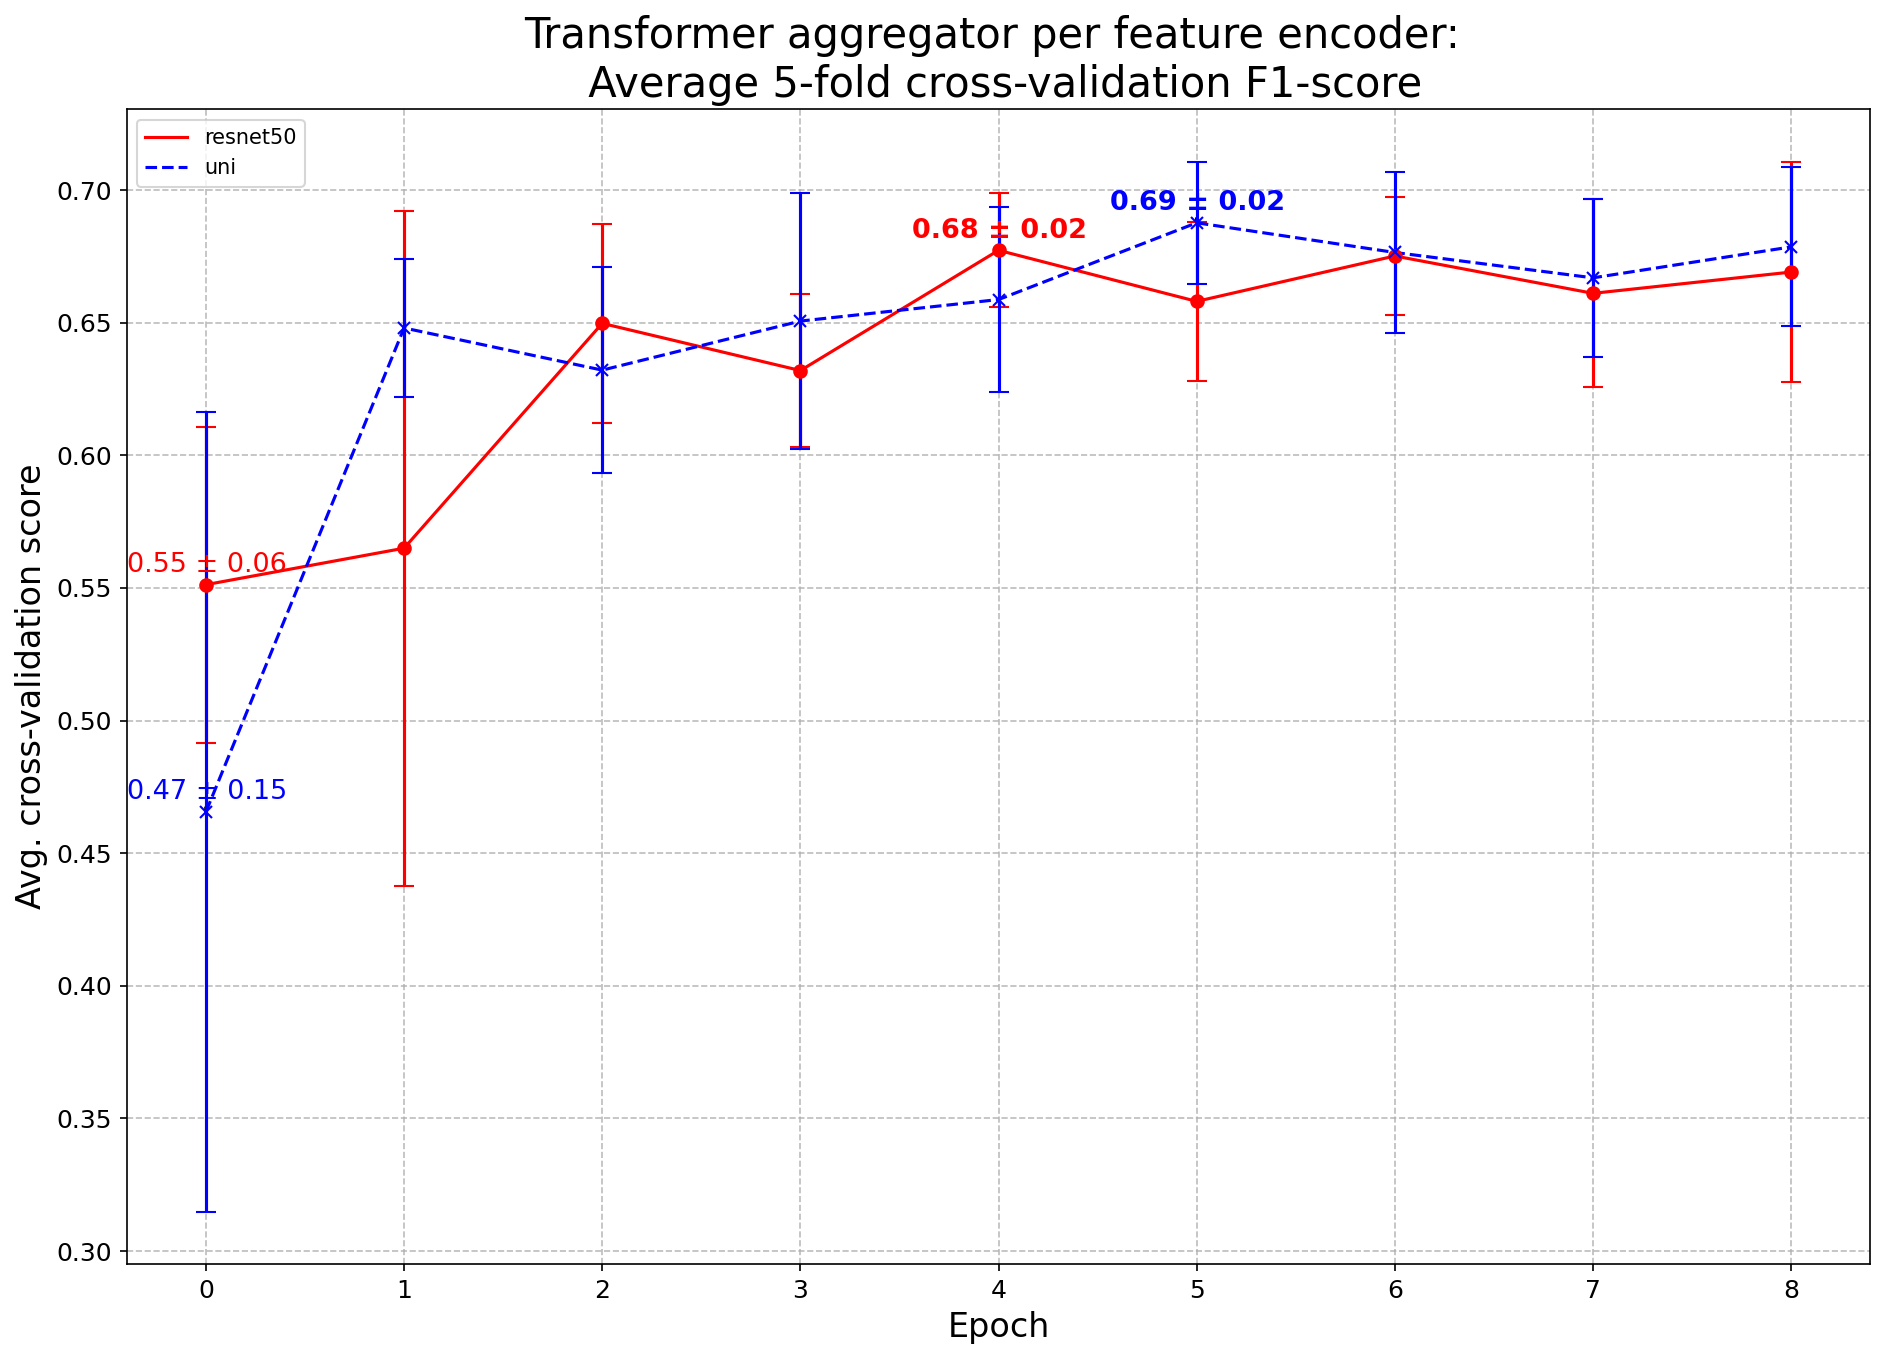

In [11]:
# get_val_metrics(runs=runs1, index=6)
# plot_results(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'Transformer aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')
plot_results_no_gigapath(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'Transformer aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')


In [15]:
np.max(uni_means), uni_stds[np.argmax(uni_means)]
np.max(resnet50_means), resnet50_stds[np.argmax(resnet50_means)]

(0.6773025631904602, 0.021554563689875857)

In [12]:
auroc_uni_means, auroc_uni_stds = get_mean_std(uni_aurocval_scores)
auroc_resnet50_means, auroc_resnet50_stds = get_mean_std(resnet50_aurocval_scores)
auroc_gigapath_means, auroc_gigapath_stds = get_mean_std(gigapath_aurocval_scores)

In [ ]:
# plot_results(uni_res = [auroc_uni_means, auroc_uni_stds], resnet_res = [auroc_resnet50_means, auroc_resnet50_stds], gigapath_res = [auroc_gigapath_means, auroc_gigapath_stds], title = 'Transformer aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')
plot_results_no_gigapath(uni_res = [auroc_uni_means, auroc_uni_stds], resnet_res = [auroc_resnet50_means, auroc_resnet50_stds], gigapath_res = [auroc_gigapath_means, auroc_gigapath_stds], title = 'Transformer aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# TransMIL

In [ ]:
entity = 'cell-x'
project = 'g0-arrest-resnet50-transmil-cv5'

runs1 = wandb.Api().runs(f"{entity}/{project}")


In [ ]:
entity = 'cell-x'
project = 'g0-arrest-uni-transmil-cv5'
runs2 =  wandb.Api().runs(f"{entity}/{project}")

In [ ]:
entity = 'cell-x'
project = 'g0-arrest-gigapath-transmil-cv5'
runs3 =  wandb.Api().runs(f"{entity}/{project}")

In [ ]:
resnet50_f1_scores_transmil, resnet50_aurocval_scores_transmil = get_val_metrics(runs=runs1, index=31)
uni_f1_scores_transmil, uni_aurocval_scores_transmil = get_val_metrics(runs=runs2, index=31)
gigapath_f1_scores_transmil, gigapath_aurocval_scores_transmil = get_val_metrics(runs=runs3, index=31)


In [ ]:

resnet50_means_transmil, resnet50_stds_transmil = get_mean_std(resnet50_f1_scores_transmil)
uni_means_transmil, uni_stds_transmil = get_mean_std(uni_f1_scores_transmil)
gigapath_means_transmil, gigapath_stds_transmil = get_mean_std(gigapath_f1_scores_transmil)

In [ ]:
# plot_results(resnet_res = [resnet50_means_transmil, resnet50_stds_transmil], \
#             uni_res = [uni_means_transmil, uni_stds_transmil], \
#             gigapath_res = [gigapath_means_transmil, gigapath_stds_transmil], title = 'TransMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')

plot_results_no_gigapath(resnet_res = [resnet50_means_transmil, resnet50_stds_transmil], \
            uni_res = [uni_means_transmil, uni_stds_transmil], \
            gigapath_res = [gigapath_means_transmil, gigapath_stds_transmil], title = 'TransMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')



In [ ]:

resnet50_means_transmil, resnet50_stds_transmil = get_mean_std(resnet50_aurocval_scores_transmil)
uni_means_transmil, uni_stds_transmil = get_mean_std(uni_aurocval_scores_transmil)
gigapath_means_transmil, gigapath_stds_transmil = get_mean_std(gigapath_aurocval_scores_transmil)

In [ ]:
plot_results(resnet_res = [resnet50_means_transmil, resnet50_stds_transmil], \
            uni_res = [uni_means_transmil, uni_stds_transmil], \
            gigapath_res = [gigapath_means_transmil, gigapath_stds_transmil], title = 'TransMIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# CAMIL
### 30 epochs

In [ ]:
entity = 'anwangxuelong'
project1 = 'g0-arrest-resnet50-cv5-camil' 
project2 = 'g0-arrest-uni-cv5-camil'
project3 = 'g0-arrest-gigapath-cv5-camil'



runs1 = wandb.Api().runs(f"{entity}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity}/{project2}")
runs3 =  wandb.Api().runs(f"{entity}/{project3}")

In [ ]:
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics(runs=runs1, index=1)


### joining cv scores due to resuming from checkpoint and deleting overlapping epochs

In [ ]:
def update_scores(scores, index_left, index_right, index_eliminate):
    
    
    resumed_scores = scores[index_left][:-index_eliminate] + scores[index_right]  # Assuming new_values is the second list

    # Replace the second list with the new F1 score
    scores[index_right] = resumed_scores

    # Remove the third list
    del scores[index_left]

    return scores

In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]
# resnet50_f1_scores[3]

In [ ]:
# resnet50_f1_score_cv1_resumed = resnet50_f1_scores[3][:-5] + resnet50_f1_scores[4] # resumed from epoch 5
# resnet50_f1_scores[1] = resnet50_f1_score_cv1_resumed
# del resnet50_f1_scores[2]
resnet50_f1_scores = update_scores(resnet50_f1_scores, index_left=3, index_right=4, index_eliminate=5)

In [ ]:
# resnet50_aurocval_scores = update_scores(resnet50_aurocval_scores, index_left=2, index_right=1, index_eliminate=5)
resnet50_aurocval_scores = update_scores(resnet50_aurocval_scores, index_left=3, index_right=4, index_eliminate=5)

In [ ]:
[len(sublist) for sublist in resnet50_aurocval_scores]
# resnet50_f1_scores[4]

In [ ]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs2, index=30)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics(runs=runs3, index=30)

resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
uni_means, uni_stds = get_mean_std(uni_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
# [np.max(sublist) for sublist in uni_means]

In [ ]:
# plot_results(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'CAMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')
plot_results_no_gigapath(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'CAMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')


In [ ]:
auroc_resnet50_means, auroc_resnet50_stds = get_mean_std(resnet50_aurocval_scores)
auroc_uni_means, auroc_uni_stds = get_mean_std(uni_aurocval_scores)
auroc_gigapath_means, auroc_gigapath_stds = get_mean_std(gigapath_aurocval_scores)

In [ ]:
# plot_results(uni_res = [auroc_uni_means, auroc_uni_stds], resnet_res = [auroc_resnet50_means, auroc_resnet50_stds], gigapath_res = [auroc_gigapath_means, auroc_gigapath_stds], title = 'CAMIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')
plot_results_no_gigapath(uni_res = [auroc_uni_means, auroc_uni_stds], resnet_res = [auroc_resnet50_means, auroc_resnet50_stds], gigapath_res = [auroc_gigapath_means, auroc_gigapath_stds], title = 'CAMIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# DTFD-MIL
### 42 epochs

In [ ]:
entity = 'anwangxuelong'
project1 = 'g0-arrest-resnet50-dtfdmil-cv5-multisteplr' 
project2 = 'g0-arrest-uni-dtfdmil-cv5-multisteplr'
project3 = 'g0-arrest-gigapath-dtfdmil-cv5-multisteplr'



runs1 = wandb.Api().runs(f"{entity}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity}/{project2}")
runs3 =  wandb.Api().runs(f"{entity}/{project3}")

In [ ]:
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics_scan(runs=runs1)


In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]


In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]
# len(resnet50_f1_scores[1][:-3] + resnet50_f1_scores[2])
len(resnet50_f1_scores[3][:-1] + resnet50_f1_scores[4])

resnet50_f1_scores = update_scores(resnet50_f1_scores, index_left=1, index_right=2, index_eliminate=3)
resnet50_aurocval_scores = update_scores(resnet50_aurocval_scores, index_left=1, index_right=2, index_eliminate=3)

# uni_f1_scores = update_scores(uni_f1_scores, index_left=2, index_right=3, index_eliminate=10)
# uni_aurocval_scores = update_scores(uni_aurocval_scores, index_left=2, index_right=3, index_eliminate=10)


In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]
resnet50_f1_scores = update_scores(resnet50_f1_scores, index_left=2, index_right=3, index_eliminate=1)
resnet50_aurocval_scores = update_scores(resnet50_aurocval_scores, index_left=2, index_right=3, index_eliminate=1)


In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]


In [ ]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics_scan(runs=runs2)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics_scan(runs=runs3)


# uni_means, uni_stds = get_mean_std(uni_f1_scores)
# gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
[len(sublist) for sublist in uni_aurocval_scores]
# len(uni_aurocval_scores[2][:-10] + uni_aurocval_scores[3])


In [ ]:
# uni_aurocval_scores[3]
# uni_f1_scores[2][:-10] + uni_aurocval_scores[3]
uni_f1_scores = update_scores(uni_f1_scores, index_left=2, index_right=3, index_eliminate=10)
uni_aurocval_scores = update_scores(uni_aurocval_scores, index_left=2, index_right=3, index_eliminate=10)


In [ ]:
[len(sublist) for sublist in gigapath_f1_scores]
len(gigapath_f1_scores[2][:-1] + gigapath_f1_scores[3])
# gigapath_f1_scores[3]
gigapath_f1_scores = update_scores(gigapath_f1_scores, index_left=2, index_right=3, index_eliminate=1)
gigapath_aurocval_scores = update_scores(gigapath_aurocval_scores, index_left=2, index_right=3, index_eliminate=1)



In [ ]:
[len(sublist) for sublist in gigapath_aurocval_scores]
[len(sublist) for sublist in uni_aurocval_scores]

In [ ]:

resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
uni_means, uni_stds = get_mean_std(uni_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
# plot_results(resnet_res = [resnet50_means, resnet50_stds], \
#             uni_res = [uni_means, uni_stds], \
#             gigapath_res = [gigapath_means, gigapath_stds], title = 'DTFD-MIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')
plot_results_no_gigapath(resnet_res = [resnet50_means, resnet50_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [gigapath_means, gigapath_stds], title = 'DTFD-MIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')


In [ ]:

resnet50_means, resnet50_stds = get_mean_std(resnet50_aurocval_scores)
uni_means, uni_stds = get_mean_std(uni_aurocval_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_aurocval_scores)

In [ ]:
plot_results(resnet_res = [resnet50_means, resnet50_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [gigapath_means, gigapath_stds], title = 'DTFD-MIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# AttentionMIL

In [ ]:
entity1 = 'cell-x'
entity2 = 'anwangxuelong'
project1 = 'g0-arrest-resnet50-attentionMIL_cv5' 
project2 = 'g0-arrest-uni-attentionMIL_cv5'
project3 = 'g0-arrest-gigapath-attentionMIL_cv5'



runs1 = wandb.Api().runs(f"{entity1}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity1}/{project2}")
runs3 =  wandb.Api().runs(f"{entity2}/{project3}")

In [ ]:
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics(runs=runs1)
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs2)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics(runs=runs3)


# uni_means, uni_stds = get_mean_std(uni_f1_scores)
# gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]


In [ ]:
[len(sublist) for sublist in uni_f1_scores]
# resnet50_f1_scores = update_scores(resnet50_f1_scores, index_left=4, index_right=3, index_eliminate=5)
# uni_f1_scores[3]
# uni_f1_scores[4]
uni_f1_scores = update_scores(uni_f1_scores, index_left=3, index_right=4, index_eliminate=1)
uni_aurocval_scores = update_scores(uni_aurocval_scores, index_left=3, index_right=4, index_eliminate=1)


In [ ]:
[len(sublist) for sublist in uni_f1_scores]


In [ ]:
[len(sublist) for sublist in gigapath_f1_scores]
gigapath_f1_scores = update_scores(gigapath_f1_scores, index_left=3, index_right=4, index_eliminate=4)
gigapath_f1_scores = update_scores(gigapath_f1_scores, index_left=4, index_right=5, index_eliminate=2)

In [ ]:
gigapath_aurocval_scores = update_scores(gigapath_aurocval_scores, index_left=3, index_right=4, index_eliminate=4)
gigapath_aurocval_scores = update_scores(gigapath_aurocval_scores, index_left=4, index_right=5, index_eliminate=2)

In [ ]:
[len(sublist) for sublist in gigapath_aurocval_scores]


In [ ]:
resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
uni_means, uni_stds = get_mean_std(uni_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
# plot_results(resnet_res = [resnet50_means,resnet50_stds], \
#             uni_res = [uni_means, uni_stds], \
#             gigapath_res = [gigapath_means, gigapath_stds], title = 'AttentionMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')
plot_results_no_gigapath(resnet_res = [resnet50_means,resnet50_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [gigapath_means, gigapath_stds], title = 'AttentionMIL aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')


In [ ]:
resnet50_means, resnet50_stds = get_mean_std(resnet50_aurocval_scores)
uni_means, uni_stds = get_mean_std(uni_aurocval_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_aurocval_scores)

In [ ]:
# plot_results(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'AttentionMIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')
plot_results_no_gigapath(uni_res = [uni_means, uni_stds], resnet_res = [resnet50_means, resnet50_stds], gigapath_res = [gigapath_means, gigapath_stds], title = 'AttentionMIL aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# GraphTransformer

In [ ]:
entity = 'anwangxuelong'
project1 = 'g0-arrest-resnet50-cv5-graph-transformer' 
project2 = 'g0-arrest-uni-cv5-graph-transformer'
project3 = 'g0-arrest-gigapath-cv5-graph-transformer'



runs1 = wandb.Api().runs(f"{entity}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity}/{project2}")
runs3 =  wandb.Api().runs(f"{entity}/{project3}")

In [ ]:
resnet50_f1_scores, resnet50_aurocval_scores = get_val_metrics(runs=runs1)
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs2)
gigapath_f1_scores, gigapath_aurocval_scores = get_val_metrics(runs=runs3)


In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]
resnet50_f1_scores = update_scores(resnet50_f1_scores, index_left=1, index_right=2, index_eliminate=6)
resnet50_aurocval_scores = update_scores(resnet50_aurocval_scores, index_left=1, index_right=2, index_eliminate=6)



In [ ]:
[len(sublist) for sublist in resnet50_f1_scores]
[len(sublist) for sublist in uni_aurocval_scores]
uni_f1_scores = update_scores(uni_f1_scores, index_left=1, index_right=2, index_eliminate=30)
uni_aurocval_scores = update_scores(uni_aurocval_scores, index_left=1, index_right=2, index_eliminate=30)


In [ ]:
[len(sublist) for sublist in uni_aurocval_scores]
[len(sublist) for sublist in gigapath_f1_scores]
gigapath_f1_scores = update_scores(gigapath_f1_scores, index_left=1, index_right=2, index_eliminate=12)
gigapath_aurocval_scores = update_scores(gigapath_aurocval_scores,index_left=1, index_right=2, index_eliminate=12)


In [ ]:
[len(sublist) for sublist in gigapath_f1_scores]
gigapath_f1_scores = update_scores(gigapath_f1_scores, index_left=4, index_right=5, index_eliminate=6)
gigapath_aurocval_scores = update_scores(gigapath_aurocval_scores, index_left=4, index_right=5, index_eliminate=6)


In [ ]:
[len(sublist) for sublist in gigapath_f1_scores]

resnet50_means, resnet50_stds = get_mean_std(resnet50_f1_scores)
uni_means, uni_stds = get_mean_std(uni_f1_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_f1_scores)

In [ ]:
# plot_results(resnet_res = [resnet50_means, resnet50_stds], \
#             uni_res = [uni_means, uni_stds], \
#             gigapath_res = [gigapath_means, gigapath_stds], title = 'Graph Transformer aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')
plot_results_no_gigapath(resnet_res = [resnet50_means, resnet50_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [gigapath_means, gigapath_stds], title = 'Graph Transformer aggregator per feature encoder: \n Average 5-fold cross-validation F1-score')


In [ ]:

resnet50_means, resnet50_stds = get_mean_std(resnet50_aurocval_scores)
uni_means, uni_stds = get_mean_std(uni_aurocval_scores)
gigapath_means, gigapath_stds = get_mean_std(gigapath_aurocval_scores)

In [ ]:
# plot_results(resnet_res = [resnet50_means, resnet50_stds], \
#             uni_res = [uni_means, uni_stds], \
#             gigapath_res = [gigapath_means, gigapath_stds], title = 'Graph Transformer aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')
plot_results_no_gigapath(resnet_res = [resnet50_means, resnet50_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [gigapath_means, gigapath_stds], title = 'Graph Transformer aggregator per feature encoder: \n Average 5-fold cross-validation AUROC score')


# Multimodal TransMIL

In [ ]:
entity = 'anwangxuelong'
# project1 = 'g0-arrest-resnet50-cv5-graph-transformer' 
project2 = 'g0-arrest-uni-transmil-multimodal-cv5'
# project3 = 'g0-arrest-gigapath-cv5-graph-transformer'



# runs1 = wandb.Api().runs(f"{entity}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity}/{project2}")
# runs3 =  wandb.Api().runs(f"{entity}/{project3}")

In [ ]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics(runs=runs2)


In [ ]:
[len(sublist) for sublist in uni_f1_scores]


In [ ]:
uni_means, uni_stds = get_mean_std(uni_f1_scores)


In [ ]:
plot_results_only_uni(resnet_res = [uni_means, uni_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [uni_means, uni_stds], title = 'TransMIL Multimodal Classification with UNI: \n Average 5-fold cross-validation F1-score')


In [ ]:
uni_means, uni_stds = get_mean_std(uni_aurocval_scores)


In [ ]:
plot_results_only_uni(resnet_res = [uni_means, uni_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [uni_means, uni_stds], title = 'TransMIL Multimodal Classification with UNI: \n Average 5-fold cross-validation AUROC-score')


# Combining DTFD-MIL-TransMIL

In [ ]:
entity = 'anwangxuelong'
# project1 = 'g0-arrest-resnet50-cv5-graph-transformer' 
project2 = 'g0-arrest-uni-dtfdtransmil-cv5'
# project3 = 'g0-arrest-gigapath-cv5-graph-transformer'



# runs1 = wandb.Api().runs(f"{entity}/{project1}") # check what happened, why are there 6 runs
runs2 =  wandb.Api().runs(f"{entity}/{project2}")
# runs3 =  wandb.Api().runs(f"{entity}/{project3}")

In [ ]:
uni_f1_scores, uni_aurocval_scores = get_val_metrics_scan(runs=runs2)


In [ ]:
[len(sublist) for sublist in uni_f1_scores]
uni_f1_scores = update_scores(uni_f1_scores, index_left=4, index_right=5, index_eliminate=7)
uni_aurocval_scores = update_scores(uni_aurocval_scores, index_left=4, index_right=5, index_eliminate=7)



In [ ]:
[len(sublist) for sublist in uni_f1_scores]


In [ ]:
uni_means, uni_stds = get_mean_std(uni_f1_scores)


In [ ]:
plot_results_only_uni(resnet_res = [uni_means, uni_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [uni_means, uni_stds], title = 'DTFD-TransMIL Classification with UNI: \n Average 5-fold cross-validation F1-score')


In [ ]:
uni_means, uni_stds = get_mean_std(uni_aurocval_scores)


In [ ]:
plot_results_only_uni(resnet_res = [uni_means, uni_stds], \
            uni_res = [uni_means, uni_stds], \
            gigapath_res = [uni_means, uni_stds], title = 'DTFD-TransMIL Classification with UNI: \n Average 5-fold cross-validation AUROC-score')


In [ ]:
wandb.finish()